In [1]:
from matplotlib import pyplot as plt
import numpy as np
import h5py
import pandas as pd
import scipy as sp
from scipy import stats
from scipy.optimize import curve_fit
from scipy import constants

In [2]:
# Parameter space  

In [16]:
M = 1
a = 0.9
theta_min = np.array([20, 70]) * np.pi / 180
inc = np.pi/2 - theta_min # prograde orbits
ecc = np.array([0.3, 0.7])
p = np.arange(3.5*M, 6.5*M, 0.0001)
rp = np.zeros(len(p)*len(ecc))
eccSel = np.zeros(len(p)*len(ecc))
pSel = np.zeros(len(p)*len(ecc))

In [4]:
count = 0
for j in range (len(ecc)):
    for h in range(len(p)):
        rp[count] = p[h] / (1 + ecc[j])
        eccSel[count] = ecc[j]
        pSel[count] = p[h]
        count += 1
#mask = rp > 4.99

In [5]:
#len(inc) * len(rp[mask])
len(inc) * len(rp)

120000

In [6]:
%%time
l = open('Init_params_explore.csv','w')
print('a', ',', 'i', ',', 'ecc', ',', 'p', file=l)
#for i in range(len(a)):
for k in range(len(inc)):
    for h in range(len(rp)):
            print(a, ',', inc[k], ',', eccSel[h], ',', pSel[h], file=l)
l.close()

CPU times: user 752 ms, sys: 30.7 ms, total: 783 ms
Wall time: 825 ms


In [17]:
# Initial p 

In [3]:
fname = 'Init_params.h5'
#data = np.zeros([9, 120000])
data = np.zeros([9, 120000], dtype=[('Re', '<f8'), ('Im', '<f8')])
data[:, :] = np.transpose(h5py.File(fname)['Dataset1'])
data.shape

(9, 120000)

In [4]:
aInput1 = np.zeros(len(data[0]))
incInput1 = np.zeros(len(data[1]))
eccInput1 = np.zeros(len(data[2]))
pInput1 = np.zeros(len(data[3]))
omegaRadial1 = np.zeros(len(data[6]))
omegaTheta1 = np.zeros(len(data[7]))
trigger1 = np.zeros(len(data[8]))

#real part
for i in range(len(data[0])):
    aInput1[i] = data[0][i][0]
    incInput1[i] = data[1][i][0]
    eccInput1[i] = data[2][i][0]
    pInput1[i] = data[3][i][0]
    omegaRadial1[i] = data[6][i][0]
    omegaTheta1[i] = data[7][i][0]
    trigger1[i] = data[8][i][0]

In [5]:
#check imag part
omegaRadialImag = np.zeros(len(data[6]))
omegaThetaImag = np.zeros(len(data[7]))

for i in range(len(data[0])):
    omegaRadialImag[i] = data[6][i][1]
    omegaThetaImag[i] = data[7][i][1]

#exclude values with imag part
omegaRadialImagMask = (omegaRadialImag != 0)
omegaThetaImagMask = (omegaThetaImag != 0)
len(omegaRadialImag[omegaRadialImagMask]), len(omegaThetaImag[omegaThetaImagMask])

(28876, 25639)

In [6]:
aInput = aInput1[~omegaRadialImagMask]
incInput = incInput1[~omegaRadialImagMask]
eccInput = eccInput1[~omegaRadialImagMask]
pInput = pInput1[~omegaRadialImagMask]
omegaRadial = omegaRadial1[~omegaRadialImagMask]
omegaTheta = omegaTheta1[~omegaRadialImagMask]
trigger = trigger1[~omegaRadialImagMask]

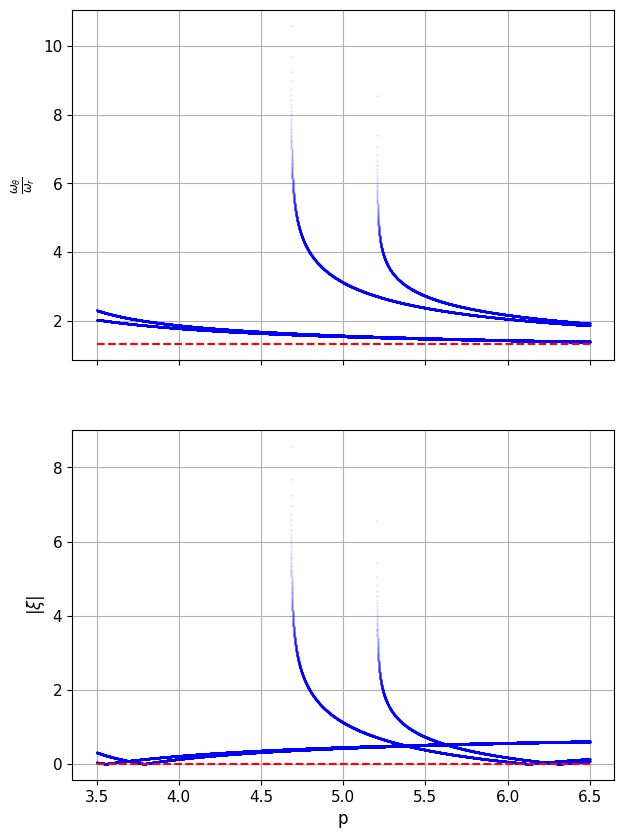

In [7]:
fig, ax1 = plt.subplots(2, figsize=(7, 10), sharex=True)

ax1[0].plot(pInput, omegaTheta / omegaRadial, '.', ms = 0.5, color = 'blue', alpha=0.3)
ax1[0].hlines(4/3 - 0.002, pInput.min(), pInput.max(), ls = 'dashed', lw = 1.5, color = 'red', alpha=1)
ax1[0].set_ylabel(r'$\frac{\omega_{\theta}}{\omega_r}$', fontsize = 12)
ax1[0].grid()
ax1[0].tick_params(axis='both', labelsize=11)

ax1[1].plot(pInput, trigger, '.', ms = 0.5, color = 'blue', alpha=0.3)
ax1[1].hlines(0.002, pInput.min(), pInput.max(), ls = 'dashed', lw = 1.5, color = 'red', alpha=1)
ax1[1].set_xlabel(r'p', fontsize = 12)
ax1[1].set_ylabel(r'$|\xi|$', fontsize = 12)
ax1[1].grid()
ax1[1].tick_params(axis='both', labelsize=11)

plt.show()
plt.close()

In [17]:
err = 3*1e-05
maskInit = (np.abs(omegaTheta / omegaRadial - (2 - 0.02)) <= err)
len(trigger[maskInit]) 

5

In [18]:
trigger[maskInit], incInput[maskInit], eccInput[maskInit], pInput[maskInit]

(array([0.01998965, 0.02002995, 0.01999911, 0.02002754, 0.01998899]),
 array([1.22173048, 1.22173048, 1.22173048, 0.34906585, 0.34906585]),
 array([0.3, 0.3, 0.7, 0.3, 0.7]),
 array([6.1764, 6.1765, 6.3609, 3.5874, 3.8174]))

In [19]:
# Save initial conditions 
l = open('Init_conds.csv','w')
print('a', ',', 'i', ',', 'ecc', ',', 'p', file=l)
for i in range(len(trigger[maskInit])):
    print(aInput[maskInit][i], ',', incInput[maskInit][i], ',', eccInput[maskInit][i], ',', pInput[maskInit][i], file=l)
l.close()

In [2]:
# Orbital frequencies evolution 

In [8]:
df = pd.read_csv('Init_conds.csv')
parspace = df.T.to_numpy()
nfile = len(parspace[0])
tResInput = np.zeros(nfile)
#tResHughes = np.zeros(nfile)
omegaRadialResInput = np.zeros(nfile)
omegaThetaResInput = np.zeros(nfile)
nfilearr = np.linspace(1, nfile, nfile)
convMass = 1.0*10**6 * 1.9891*10**30 #Kg
convTime = convMass * constants.G / constants.c**3; #s
day = 60*60*24
hour = 60*60

In [9]:
ttmaxArr = np.array([0.15, 0.4, 0.15, 0.15])*10**6 #G=c=1 

In [10]:
for i in range(0, nfile): 
    fname = 'tRes/orb_freq_evolution_'+str(i+1)+'.h5'
    nupdates = h5py.File(fname)['Dataset1'].shape[0]
    ncol = h5py.File(fname)['Dataset1'].shape[1]
    dataa2 = np.zeros([ncol, nupdates])
    dataa2[:, :] = np.transpose(h5py.File(fname)['Dataset1'])
    ttmax = ttmaxArr[i]
    dt = 100
    ttt = np.linspace(0, ttmax - dt, nupdates)
    omegaRadialTT = dataa2[0]
    omegaThetaTT = dataa2[1]
    triggerTT = dataa2[2]
    arg = np.argmin(triggerTT) 
    omegaRadialResInput[i] = omegaRadialTT[arg]
    omegaThetaResInput[i] = omegaThetaTT[arg]
    ffOmegaRadial = sp.interpolate.CubicSpline(ttt, omegaRadialTT)
    ffOmegaTheta = sp.interpolate.CubicSpline(ttt, omegaThetaTT)
    ffOmegaRadialDer = ffOmegaRadial.derivative()
    ffOmegaThetaDer = ffOmegaTheta.derivative()
    tResInput[i] = np.sqrt( (4*np.pi)/(np.abs(-2*ffOmegaRadialDer(ttt[arg]) + 1*ffOmegaThetaDer(ttt[arg]))))
    #tResInput[i] = np.sqrt( (2*np.pi)/(np.abs(-2*ffOmegaRadialDer(ttt[arg]) + 1*ffOmegaThetaDer(ttt[arg]))))
    #tResHughes[i] = 2 * np.sqrt( 2/(-2*ffOmegaRadialDer(ttt[arg]) + 1*ffOmegaThetaDer(ttt[arg])) )
csiStarInput = np.abs( -2*np.pi / (tResInput*omegaRadialResInput) )
#csiStarInput_Hughes = np.abs( -np.pi / (tResHughes*omegaRadialResInput) )

1 41100.0 35300.0 35357.46875256744


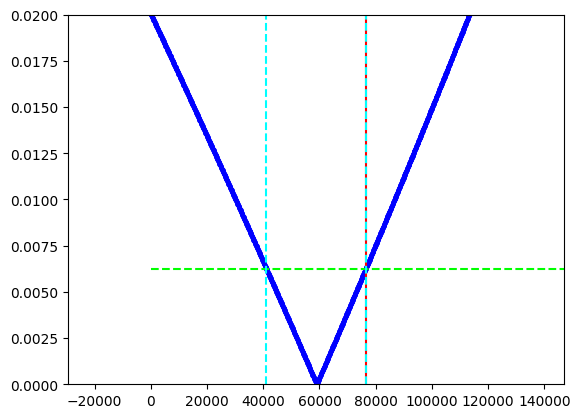

2 78200.0 64800.0 64838.97599137188


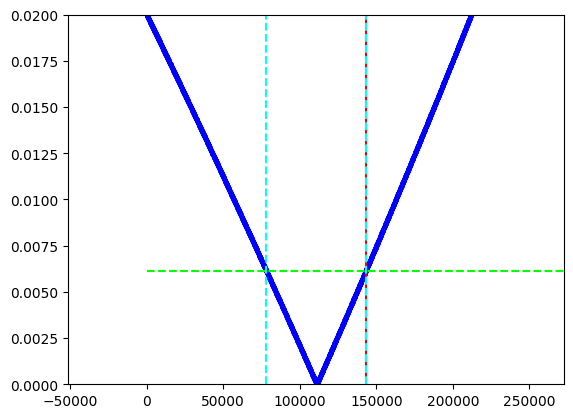

3 5700.0 11600.0 11741.551378479262


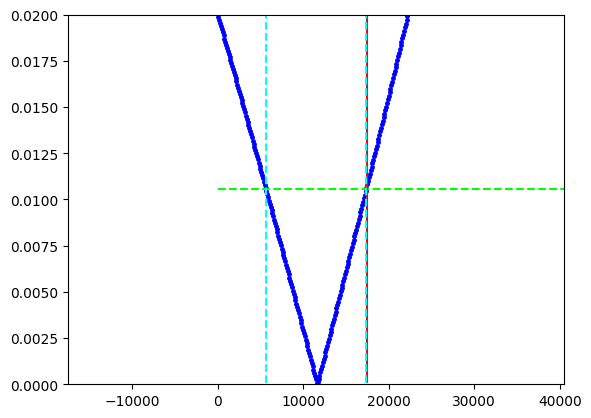

4 21700.0 26600.0 26671.469647875263


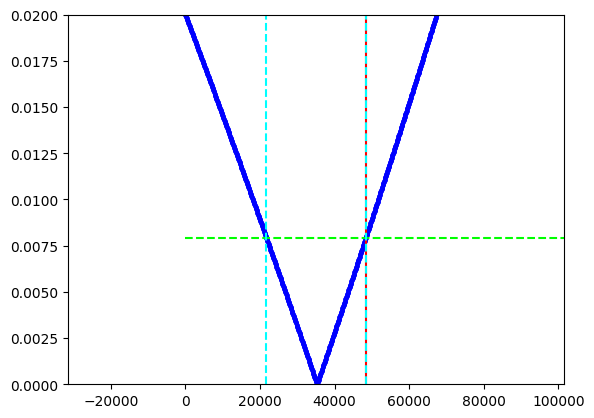

In [11]:
# Check csiStar vs tRes
tResInput2 = np.zeros(nfile)
tStartInput = np.zeros(nfile)
tEndInput = np.zeros(nfile)
for i in range(0, nfile): 
    fname = 'tRes/orb_freq_evolution_'+str(i+1)+'.h5'
    nupdates = h5py.File(fname)['Dataset1'].shape[0]
    ncol = h5py.File(fname)['Dataset1'].shape[1]
    dataa2 = np.zeros([ncol, nupdates])
    dataa2[:, :] = np.transpose(h5py.File(fname)['Dataset1'])
    ttmax = ttmaxArr[i]
    dt = 100
    ttt = np.linspace(0, ttmax - dt, nupdates)
    omegaRadialTT = dataa2[0]
    omegaThetaTT = dataa2[1]
    triggerTT = dataa2[2]
    arg = np.argmin(triggerTT) 
    maskResStart = (csiStarInput[i] > triggerTT)
    tStartInput[i] = ttt[maskResStart][0] 
    tEndInput[i] = ttt[maskResStart][-1] 
    tResInput2[i] = tEndInput[i] - tStartInput[i]
    
    print(i+1, tStartInput[i], tResInput2[i], tResInput[i])
    
    plt.plot(ttt, triggerTT, '.', ms=5, color = 'blue')
    plt.hlines(csiStarInput[i], ttt.min(), ttt.max(), ls = 'dashed', color = 'lime')
    #plt.hlines(csiStarInput_Hughes[i], ttt.min(), ttt.max(), ls = 'dashed', color = 'yellow')
    plt.vlines(tStartInput[i]+tResInput[i], triggerTT.min(), triggerTT.max(), ls = '-', color = 'red')
    plt.vlines(tStartInput[i], triggerTT.min(), triggerTT.max(), ls = 'dashed', color = 'cyan')
    plt.vlines(tEndInput[i], triggerTT.min(), triggerTT.max(), ls = 'dashed', color = 'cyan')
    #plt.vlines(ttt[arg], triggerTT.min(), triggerTT.max(), ls = 'dashed', color = 'yellow')    
    #plt.vlines(tStartInput[i]+tResInput_bis[i], triggerTT.min(), triggerTT.max(), ls = '-', color = 'yellow')
    plt.xlim(tStartInput[i]-2*tResInput2[i], tEndInput[i]+2*tResInput2[i])
    plt.ylim(0, 0.02)
    plt.show()
    plt.close()

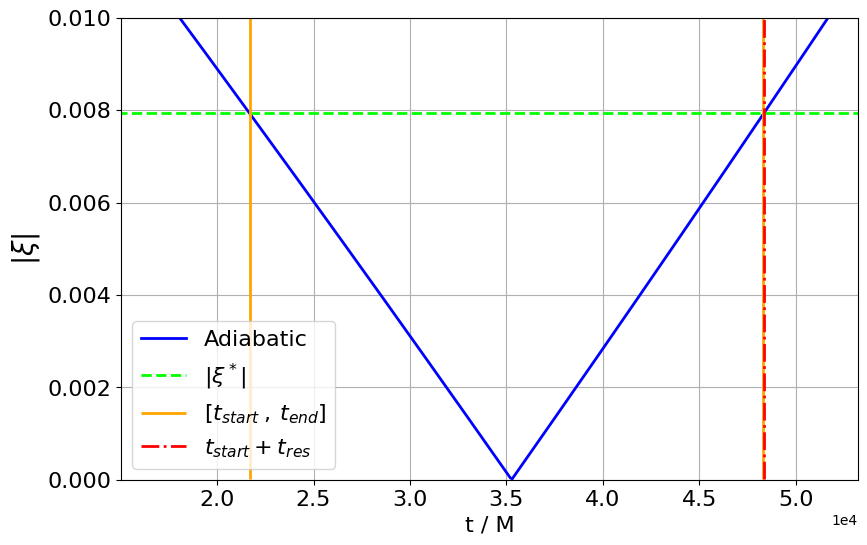

In [18]:
fig, ax1 = plt.subplots(figsize=(9.5, 6), dpi=100)
ax1.plot(ttt, triggerTT, '-', lw=2, color = 'blue', label = 'Adiabatic')
ax1.hlines(csiStarInput[i], ttt.min(), ttt.max(), lw = 2, ls = 'dashed', color = 'lime', label = r'$|\xi^*|$')
ax1.vlines(tStartInput[i], triggerTT.min(), triggerTT.max(), lw = 2, color = 'orange', label = r'$[t_{start} \:, \: t_{end}]$')
ax1.vlines(tEndInput[i], triggerTT.min(), triggerTT.max(), lw = 2, color = 'orange')
plt.vlines(tStartInput[i]+tResInput[i], triggerTT.min(), triggerTT.max(), lw = 2, ls = 'dashdot', color = 'red', label = r'$t_{start} + t_{res}$')
ax1.set_xlabel(r't / M', fontsize = 16)
ax1.set_ylabel(r'$|\xi|$', fontsize = 20)
ax1.grid()
ax1.tick_params(axis='both', labelsize=16)
ax1.ticklabel_format(axis='x', style='sci', scilimits = (0,0))
ax1.legend(fontsize = 16)
ax1.set_xlim(tStartInput[i]-tResInput[i]/4, np.max([tStartInput[i]+tResInput[i], tEndInput[i]])*1.1)
plt.ylim(0, 0.01)
#plt.savefig('res_start_end_21.png', dpi=200, bbox_inches='tight')
plt.show()
plt.close()

In [15]:
csiStarInput

array([0.00625617, 0.00613031, 0.01057847, 0.00793715])

In [16]:
# Ref. 1208.3906
coeff_E = np.array([0.004, 0.662, 0.131, 0.167])
coeff_Lz = np.array([0.080, 0.270, 0.179, 0.067])
coeff_Q = np.array([0.002, 0.494, 0.046, 0.357])

In [17]:
# Save initial conditions + resonance duration, starting / ending time
l = open('Parameter_space_21.csv','w')
print('a', ',', 'i', ',', 'ecc', ',', 'p', ',', 'tResStart', ',', 'tRes', ',', 'E', ',', 'Lz', ',', 'Q', ',', 'trigger', file=l)
for i in range(len(tResInput2)):
    print(parspace[0][i], ',', parspace[1][i], ',', parspace[2][i], ',', parspace[3][i], ',', tStartInput[i], ',', tResInput[i], ',', coeff_E[i], ',', coeff_Lz[i], ',', coeff_Q[i], ',', csiStarInput[i], file=l)
l.close()

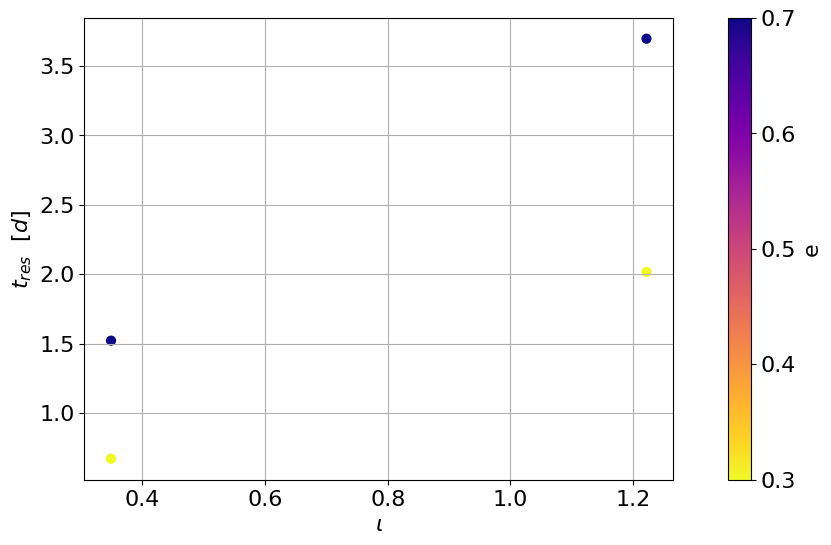

In [30]:
fig, ax1 = plt.subplots(figsize=(9.5, 6), dpi=100)
p = ax1.scatter(parspace[1], tResInput*convTime/day,  c = parspace[2], cmap='plasma_r', s = 40, marker = 'o')
ax1.set_xlabel(r'$\iota$', fontsize = 16)
ax1.set_ylabel(r'$t_{res}$  $[d]$', fontsize = 16)
ax1.grid()
ax1.tick_params(axis='both', labelsize=16)
aticks = np.arange(0.1, 0.9, 0.1)
#cbar = fig.colorbar(p, ax=ax1, ticks=aticks, shrink = 1, anchor=(0.2, 0.5), label = r'e')
cbar = fig.colorbar(p, ax=ax1, ticks=aticks, shrink = 1, anchor=(0.2, 0.5), label = r'e')
cbar.ax.tick_params(labelsize=16)
cbar.set_label(r'e', fontsize=16)
#plt.savefig('plot/kerr_tRes/tRes_vs_inc.png', dpi=200, bbox_inches='tight')
plt.show()
plt.close()

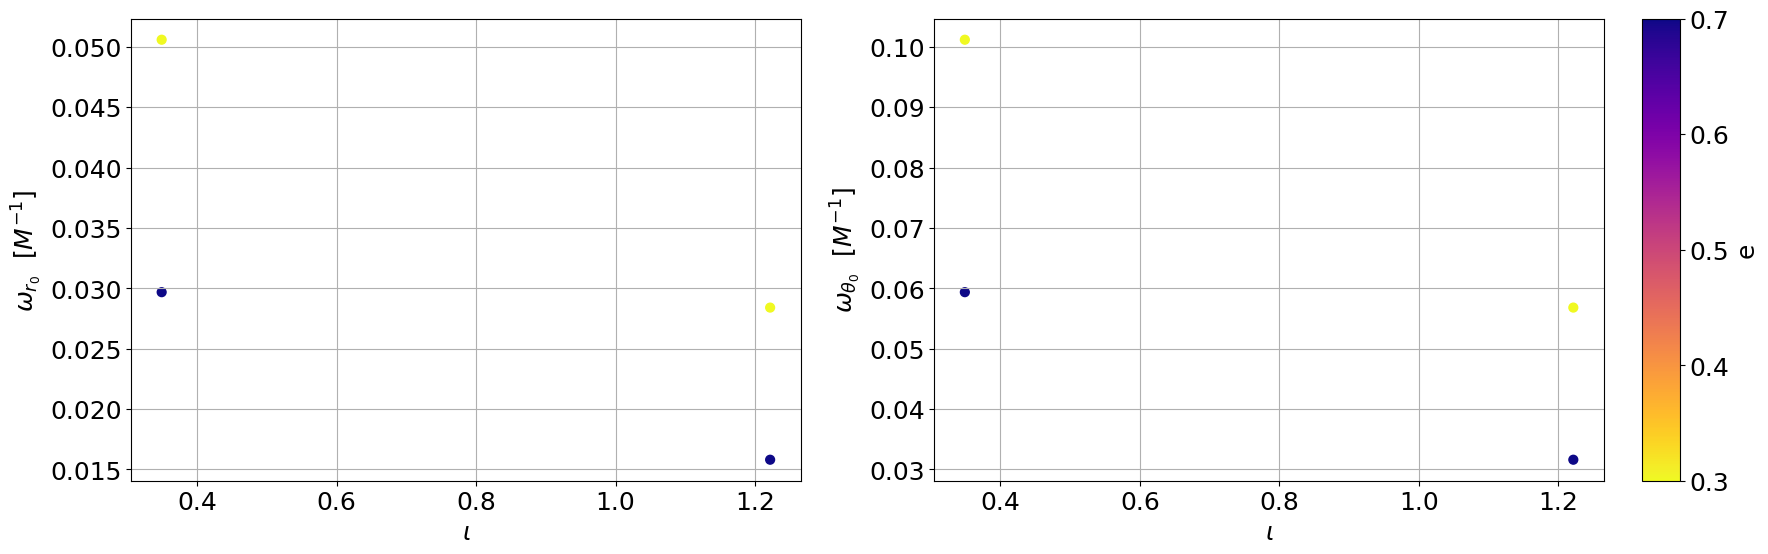

In [31]:
fig, ax1 = plt.subplots(1, 2, figsize=(19, 6), dpi=100)

p = ax1[0].scatter(parspace[1], omegaRadialResInput,  c = parspace[2], cmap='plasma_r', s = 40, marker = 'o')
ax1[0].set_xlabel(r'$\iota$', fontsize = 18)
ax1[0].set_ylabel(r'$\omega_{r_{0}}$  $[M^{-1}]$', fontsize = 18)
ax1[0].grid()
ax1[0].tick_params(axis='both', labelsize=18)

p = ax1[1].scatter(parspace[1], omegaThetaResInput,  c = parspace[2], cmap='plasma_r', s = 40, marker = 'o')
ax1[1].set_xlabel(r'$\iota$', fontsize = 18)
ax1[1].set_ylabel(r'$\omega_{\theta_{0}}$  $[M^{-1}]$', fontsize = 18)
ax1[1].grid()
ax1[1].tick_params(axis='both', labelsize=18)

plt.subplots_adjust(wspace=0.2)
cbar_ax = fig.add_axes([0.92, 0.11, 0.02, 0.77])
aticks = np.arange(0.1, 0.9, 0.1)
#fig.colorbar(p, cax=cbar_ax, ticks=aticks, label = r'$e$', location = 'right')
cbar = fig.colorbar(p, cax=cbar_ax, ticks=aticks, location = 'right')
cbar.ax.tick_params(labelsize=18)
cbar.set_label(r'e', fontsize=18)

#plt.savefig('plot/kerr_tRes/omega_vs_inc.png', dpi=200, bbox_inches='tight')
plt.show()
plt.close()